In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import us
import requests

# Read in and Clean Data

### Spending Data

In [44]:
spending = pd.read_excel('data/IIJA FUNDING AS OF MARCH 2023.xlsx', engine = 'openpyxl', names=['area','spending'])

spending.area = spending.area.str.lower()
spending.loc[spending.area == 'deleware', 'area'] = 'delaware'

print(
    spending.head(),
    '\n\n',
    spending.tail()
)

             area  spending
0         alabama    3.0000
1          alaska    3.7000
2  american samoa    0.0686
3         arizona    3.5000
4        arkansas    2.8000 

              area  spending
52       virginia       4.5
53     washington       4.0
54  west virginia       2.0
55      wisconsin       2.8
56        wyoming       2.3


### Population Data

In [45]:
population = pd.read_excel(
    'https://www2.census.gov/programs-surveys/popest/tables/2020-2023/state/totals/NST-EST2023-POP.xlsx',
    engine='openpyxl', header=3
)

population.columns = ['area', 'pop_base', 'pop2020', 'pop2021', 'pop2022', 'pop2023']
population.area = population.area.str.replace('.', '', regex=False)
population.area = population.area.str.lower()
population = population.dropna(axis=0, how='any')

print(
    population.head(7),
    '\n\n',
    population.tail()
)

            area     pop_base      pop2020      pop2021      pop2022  \
0  united states  331464948.0  331526933.0  332048977.0  333271411.0   
1      northeast   57614141.0   57430477.0   57243423.0   57026847.0   
2        midwest   68987296.0   68969794.0   68850246.0   68783028.0   
3          south  126268529.0  126465281.0  127353282.0  128702030.0   
4           west   78594982.0   78661381.0   78602026.0   78759506.0   
5        alabama    5024294.0    5031864.0    5050380.0    5073903.0   
6         alaska     733374.0     732964.0     734923.0     733276.0   

       pop2023  
0  334914895.0  
1   56983517.0  
2   68909283.0  
3  130125290.0  
4   78896805.0  
5    5108468.0  
6     733406.0   

              area   pop_base    pop2020    pop2021    pop2022    pop2023
52     washington  7705267.0  7724566.0  7741433.0  7784477.0  7812880.0
53  west virginia  1793713.0  1791562.0  1785249.0  1774035.0  1770071.0
54      wisconsin  5893713.0  5896700.0  5879978.0  5890543.0  59

### Party Data

In [46]:
election_results = pd.read_csv('data/1976-2020-president.csv')
election_results = election_results.loc[election_results.year == 2020]

idx = election_results.groupby('state')['candidatevotes'].idxmax()
state_by_winner = election_results.loc[idx]
state_by_winner = state_by_winner[['state', 'candidate']]
state_by_winner['party'] = np.where(state_by_winner['candidate'] == 'BIDEN, JOSEPH R. JR', 'dem', 'rep')
state_by_winner['state'] = state_by_winner['state'].str.lower()

print(
    state_by_winner.head(),
    '\n\n',
    state_by_winner.tail()
)

           state            candidate party
3741     alabama     TRUMP, DONALD J.   rep
3745      alaska     TRUMP, DONALD J.   rep
3752     arizona  BIDEN, JOSEPH R. JR   dem
3771    arkansas     TRUMP, DONALD J.   rep
3773  california  BIDEN, JOSEPH R. JR   dem 

               state            candidate party
4252       virginia  BIDEN, JOSEPH R. JR   dem
4256     washington  BIDEN, JOSEPH R. JR   dem
4264  west virginia     TRUMP, DONALD J.   rep
4267      wisconsin  BIDEN, JOSEPH R. JR   dem
4281        wyoming     TRUMP, DONALD J.   rep


### Debt Data

In [47]:
debt = pd.read_excel(
    'https://www2.census.gov/programs-surveys/gov-finances/tables/2021/21slsstab1.xlsx', 
    engine='openpyxl', header=10, index_col=1
)

states = []
current_state = None

for col in debt.columns:
    current_state = col.lower() if 'Unnamed' not in col else current_state
    states.append(current_state)

debt.iloc[1,:] = states

debt.columns = states

debt = debt.loc[:, debt.iloc[0, :] == ' State']

debt.index = debt.index.str.strip()

debt = pd.DataFrame({
    'state' : debt.loc['Debt outstanding'].T.index,
    'debt' : debt.loc['Debt outstanding'].T
})

print(
    debt.head(),
    '\n\n',
    debt.tail()
)

                                   state        debt
united states total  united states total  1208170688
alabama                          alabama     9118128
alaska                            alaska     5652311
arizona                          arizona     8969733
arkansas                        arkansas     7868953 

                        state      debt
virginia            virginia  31041855
washington        washington  30206602
west virginia  west virginia  13368743
wisconsin          wisconsin  21978336
wyoming              wyoming    924246


# Merge Datasets

In [48]:
print(
    population.area[~population.area.isin(spending.area)],'\n\n',
    spending.area[~spending.area.isin(population.area)]
)

0    united states
1        northeast
2          midwest
3            south
4             west
Name: area, dtype: object 

 2               american samoa
12                        guam
37    northern mariana islands
48          tribal communities
49           us virgin islands
Name: area, dtype: object


In [49]:
data = pd.merge(population, spending, on='area', how='inner')

data = pd.merge(data, state_by_winner, left_on='area', right_on='state', how='inner')
## FIX TO KEEP PR

data = pd.merge(data, debt, left_on='area', right_on='state', how='inner')

In [50]:
data['spending_per_capita'] = (data['spending'] * 10**9) / data['pop2023']
data['debt_per_capita'] = (data['debt'] * 1000) / data['pop2023']

In [51]:
mapping = us.states.mapping('name', 'abbr')
mapping = {key.lower(): value for key, value in mapping.items()}

data['area_abbr'] = data['area'].map(mapping)
data.loc[data.area_abbr.isnull(), 'area_abbr'] = 'DC'

# Plots

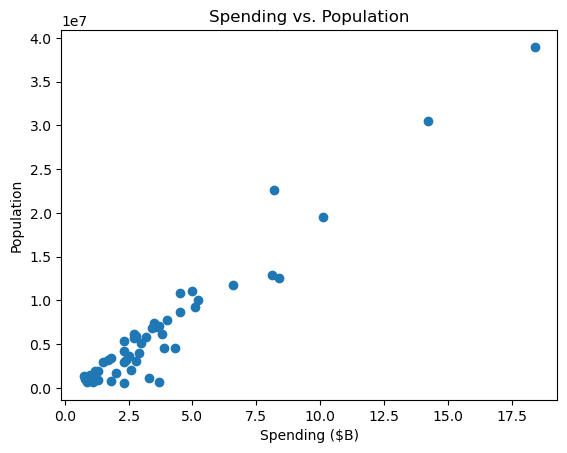

In [52]:
fig, ax = plt.subplots()
ax.scatter(data.spending, data.pop2023)
ax.set_xlabel('Spending ($B)')
ax.set_ylabel('Population')
ax.set_title('Spending vs. Population')
plt.show()

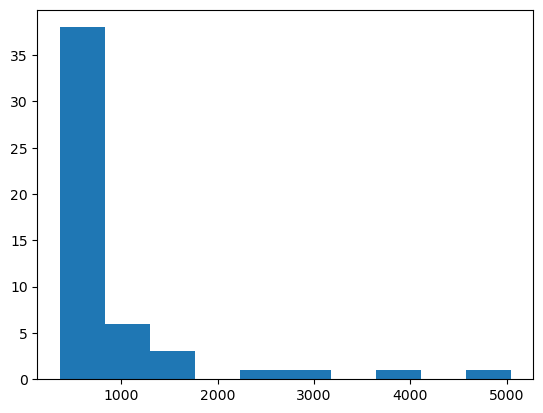

In [53]:
fig, ax = plt.subplots()
ax.hist(data.spending_per_capita)
plt.show()

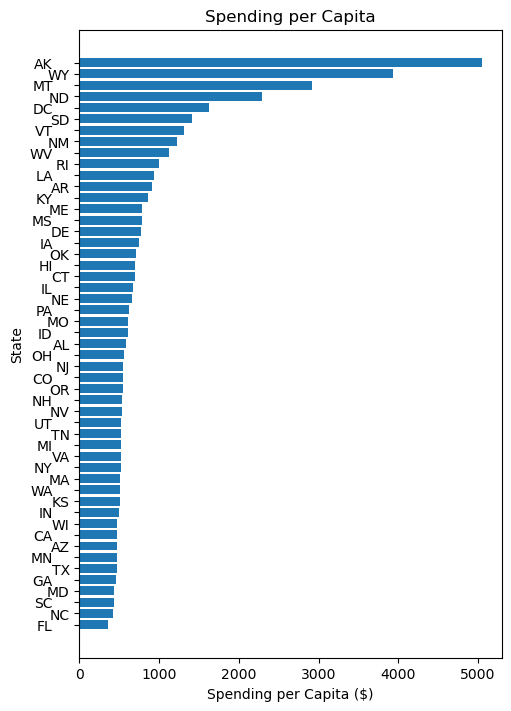

In [54]:
fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))
ax.barh('area_abbr', 'spending_per_capita', data = data.sort_values(by = 'spending_per_capita'))
ax.set_title('Spending per Capita')
ax.set_xlabel('Spending per Capita ($)')
ax.set_ylabel('State')

for i, label in enumerate(ax.get_yticklabels()):
    if i % 2 == 0: 
        label.set_position((-0.04, 0))

plt.show()

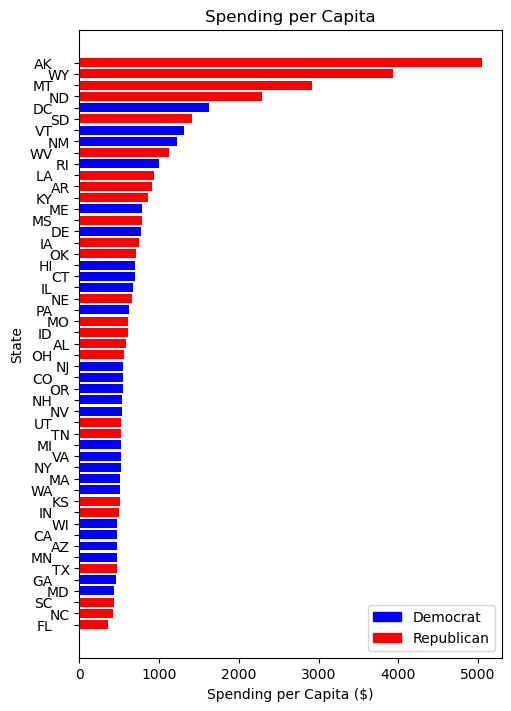

In [55]:
data = data.sort_values(by = 'spending_per_capita')
colors = {'dem':'blue', 'rep':'red'}

fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))
for i in range(len(data)):
    row = data.iloc[i]
    bar = ax.barh(
        row['area_abbr'], row['spending_per_capita'], 
        color = colors[row['party']],
    )
ax.set_title('Spending per Capita')
ax.set_xlabel('Spending per Capita ($)')
ax.set_ylabel('State')

blue_patch = mpatches.Patch(color = 'blue', label = 'Democrat')
red_patch = mpatches.Patch(color = 'red', label = 'Republican')
ax.legend(handles = [blue_patch, red_patch]) # bar, colors)

for i, label in enumerate(ax.get_yticklabels()):
    if i % 2 == 0: 
        label.set_position((-0.04, 0))

plt.show()

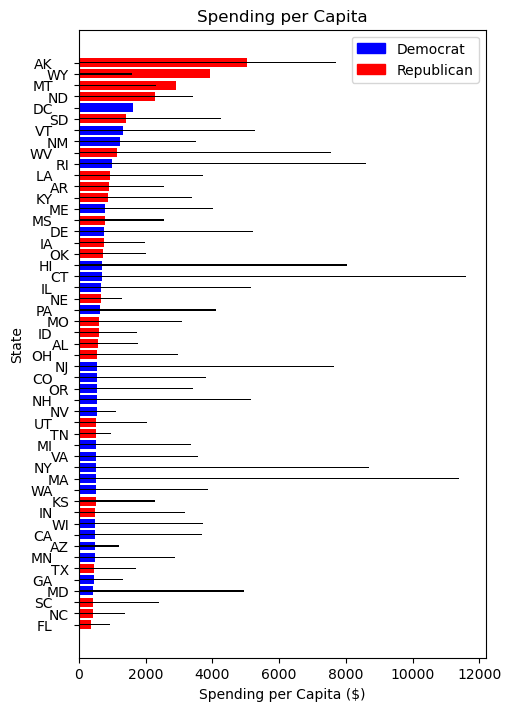

In [56]:
fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))
for i in range(len(data)):
    row = data.iloc[i]
    bar = ax.barh(
        row['area_abbr'], row['spending_per_capita'], 
        color = colors[row['party']],
    )
ax.barh(
    'area_abbr', 'debt_per_capita', 
    data = data, height = 0.1, color = 'black'
)

ax.set_title('Spending per Capita')
ax.set_xlabel('Spending per Capita ($)')
ax.set_ylabel('State')

blue_patch = mpatches.Patch(color = 'blue', label = 'Democrat')
red_patch = mpatches.Patch(color = 'red', label = 'Republican')
ax.legend(handles = [blue_patch, red_patch]) # bar, colors)

for i, label in enumerate(ax.get_yticklabels()):
    if i % 2 == 0: 
        label.set_position((-0.04, 0))

plt.show()